Play with VFTS 682

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import sys
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/')
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/')
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from plot_defaults import *
from clean_data import *
from File_reader import reader
from termcolor import colored


In [16]:
# Load data Gaia DR2 for VFTS682
# GAIA ID: 4657685637907503744,

mu_ra = 1.8429766110812542  # marsec/yr 
err_mu_ra = 0.06974150031513375  # marsec/yr

mu_dec =  0.7855134899438113  # marsec/yr
err_mu_dec = 0.07997805252521194  # masec/yr

# # Load RV from Bestenlehner et al. 2011 (http://adsabs.harvard.edu/abs/2011A%26A...530L..14B)
# radial velocity is missing in DR2
# # from HeII4686
rv = 315     # km/s
err_rv = 15  # km/s

rv_30Dor = 270  # km/s
err_rv_30Dor = 10  # km/s


# # peculiar RV
drv = rv_30Dor - rv  
err_drv = err_rv+err_rv_30Dor

# # Distance, assumed
D = 50e3  # pc

# parallax
parallax = -0.02213454741230581
e_parallax = 0.043642011613831244

# position on the sky
RAvfts682   = 84.73136339876477
e_RAvfts682 = 0.036321212008208974
DEvfts682   = -69.07411071794998
e_RAvfts682 = 0.04825647078875183

In [17]:
def convertDpc_to_km(D):
    return D*3.086e13

def convertyr_to_sec(T):
    return T*3.1558149984e7

def convertmarcsec_to_rad(alpha):
    return alpha*math.pi/(648000000.0)

def prop_motion_to_km_s(mu, D):
    # D needs to be in parsec
    # mu in milliarcsec/yr
    return convertDpc_to_km(D)*(mu/convertyr_to_sec(1))*convertmarcsec_to_rad(1)


In [18]:
## read data around this star from simbad    

# get filename and header
def getFileData(fname):
    src = np.genfromtxt(fname,
                        comments='#', skip_header=60,
                        delimiter='|', filling_values=-99998)
    ff = open(fname,'r')
    for i,line in enumerate(ff):
        if i==59:
            # print i
            col = line.split('|')
            break
    ff.close()
    # print col
    return src, col

# read file
def getData(fname):
    src, col = getFileData(fname)
    
    # proper motion RA
    pmRA = src[:, col.index('pmRA')]
    i_pmRA = pmRA != -99998
    
    e_pmRA = src[:, col.index('e_pmRA')]
    i_e_pmRA = e_pmRA != 99998 
    
    # proper motion DEC
    pmDE = src[:, col.index('pmDE')]
    i_pmDE = pmDE != -99998
    
    e_pmDE = src[:, col.index('e_pmDE')]
    i_e_pmDE = e_pmDE != 99998 
    
    # positions
    RA = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('RA_ICRS')]
    DE = src[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE, col.index('DE_ICRS')]
    
    # select data that have good proper motion and errors only
    pmDE = pmDE[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    pmRA = pmRA[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_pmDE = e_pmDE[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    e_pmRA = e_pmRA[i_pmDE*i_pmRA*i_e_pmRA*i_e_pmDE]
    
    return pmRA, e_pmRA, pmDE, e_pmDE, RA, DE

# load data
fname_R136='/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/25arcsec_R136a.tsv'
pmRA_R136, e_pmRA_R136, pmDE_R136, e_pmDE_R136, RA_R136, DE_R136 = getData(fname_R136)

fname_around='/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/10arcmin_aroundVFTS682.txt'
pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, DE_around = getData(fname_around)


# put all together
pmRA = np.concatenate((pmRA_around, pmRA_R136))
pmDE = np.concatenate((pmDE_around, pmDE_R136))
RA = np.concatenate((RA_around, RA_R136))
DE = np.concatenate((DE_around, DE_R136))


In [27]:
def plotVFTS682(ax):
    ax.quiver(RAvfts682,DEvfts682,mu_ra, mu_dec, color='r', label='VFTS682')
    ax.scatter(RAvfts682,DEvfts682, color='r', marker='x',lw=3, s=100, zorder=10)

def mkPlot(ax, pmDE, pmRA, DE, RA, color='b'):
    # notation
    x = pmRA
    y = pmDE
    xx = RA
    yy = DE
       
    #where the stars are
    ax.scatter(xx,yy,alpha=0.5, color=color)

    # # their proper motion
    ax.quiver(xx,yy,x,y)
    
    # beautification
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # ax.yaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    # ax.xaxis.set_major_locator(MultipleLocator(0.2))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))


    ax.set_ylabel(r'$\delta\ \mathrm{[degrees]}$ ',fontsize=30)
    ax.set_xlabel(r'$\mathrm{RA}\ \mathrm{[degrees]}$',fontsize=30)
    
    ax.tick_params(axis='both', which='major', width=2,
                   length=12, pad=10)
    ax.tick_params(axis='both', which='minor', width=2,
                   length=6, pad=10)
    


-69.10904244034 -69.09578463725
84.66152258499 84.69886665793


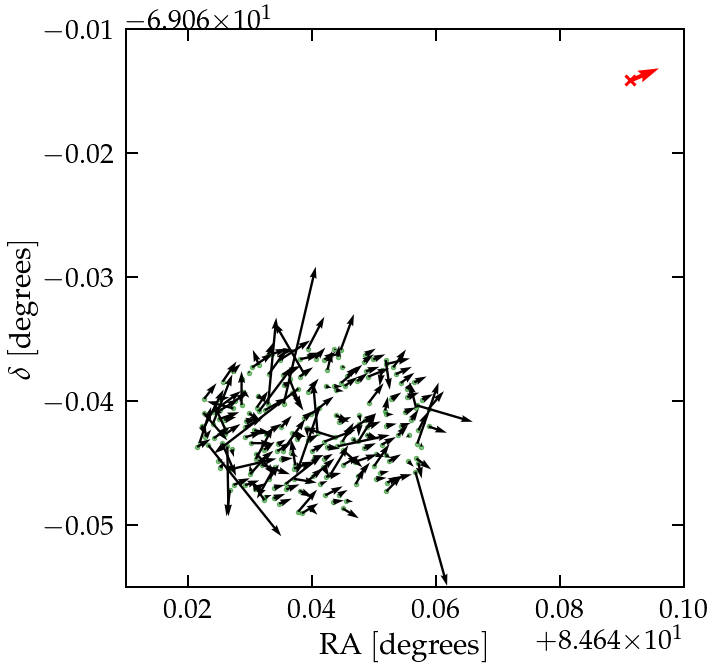

In [28]:
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])

mkPlot(ax, pmDE_R136, pmRA_R136, DE_R136, RA_R136, color='g')
plotVFTS682(ax)
print min(DE_R136),max(DE_R136)
print min(RA_R136),max(RA_R136)


In [29]:
# make averages
# TODO: improve this to take in account errorbars
avg_pmDE = np.sum(pmDE_R136)/len(pmDE_R136)
avg_pmRA = np.sum(pmRA_R136)/len(pmRA_R136)

#print avg_vDE_kms,avg_vRA_kms


In [30]:
# convert to physical velocities

# averages
avg_vRA_kms = prop_motion_to_km_s(avg_pmRA, D)
avg_vDE_kms = prop_motion_to_km_s(avg_pmDE, D)

# VFTS 682
v_ra = prop_motion_to_km_s(mu_ra, D)
v_dec = prop_motion_to_km_s(mu_dec, D)


In [31]:
## make the peculiar velocity components on the plane of the sky
dvra = avg_vRA_kms - v_ra
dvdec = avg_vDE_kms - v_dec
print dvra, dvdec

-25.173286284897472 24.075747884705066


In [32]:
# physical peculiar velocity (using RV from Bestenlehner et al. 2011)

vpec3D = math.sqrt(dvra*dvra+dvdec*dvdec+drv*drv)
print vpec3D

56.9063790676


In [ ]:

print "VFTS682 physical velocity"
print "v_ra [km/s] = ", v_ra
print "v_dec [km/s] = ", v_dec
print "v_los [km/s] = ", rv
print "|v| [km/s] = ", math.sqrt(rv*rv+v_ra*v_ra+v_dec*v_dec)
print "========================"


# drv, "This is the peculiar one, not the real physical RV"